CMPU 250 | Class 1 | Intro to NumPy and Pandas

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn as sk

In [76]:
# load cleaned data
df = pd.read_csv("../data/clean-data/cleaned_nys_data.csv")
df_original = df.copy()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233144 entries, 0 to 233143
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   action_taken                       233144 non-null  int64  
 1   derived_race                       233144 non-null  object 
 2   derived_ethnicity                  233144 non-null  object 
 3   applicant_sex                      233144 non-null  int64  
 4   applicant_age                      233144 non-null  object 
 5   income                             226538 non-null  float64
 6   debt_to_income_ratio               100684 non-null  float64
 7   applicant_credit_score_type        233144 non-null  int64  
 8   loan_amount                        233144 non-null  float64
 9   loan_to_value_ratio                224447 non-null  float64
 10  interest_rate                      176143 non-null  float64
 11  rate_spread                        1519

/var/folders/bk/9ksdjj7n47qdwk9fmh_w5rbc0000gn/T/ipykernel_51577/3631927805.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean-data/cleaned_nys_data.csv")


,action_taken,derived_race,derived_ethnicity,applicant_sex,applicant_age,income,debt_to_income_ratio,applicant_credit_score_type,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,loan_type,loan_purpose,lien_status,property_value,occupancy_type,tract_minority_population_percent,aus-1,denial_reason-1
0,1,Black or African American,Not Hispanic or Latino,2,45-54,104.0,37.0,1,395000.0,96.500,7.125,1.054,2,1,1,405000.0,1,21.09,3,10
1,1,White,Not Hispanic or Latino,1,45-54,79.0,NaN,2,255000.0,96.500,6.250,0.458,2,1,1,265000.0,1,63.55,3,10
2,1,White,Not Hispanic or Latino,1,25-34,174.0,37.0,2,605000.0,80.000,6.125,-0.232,1,1,1,755000.0,1,25.74,1,10
3,1,White,Not Hispanic or Latino,2,25-34,178.0,37.0,2,485000.0,80.000,6.750,-0.038,1,1,1,615000.0,1,13.10,1,10
4,1,Asian,Not Hispanic or Latino,1,25-34,125.0,38.0,2,335000.0,45.653,6.750,-0.012,1,1,1,735000.0,1,32.22,1,10


In [77]:
df.describe()

,action_taken,applicant_sex,income,debt_to_income_ratio,applicant_credit_score_type,loan_amount,loan_to_value_ratio,interest_rate,loan_type,loan_purpose,lien_status,property_value,occupancy_type,tract_minority_population_percent,aus-1,denial_reason-1
count,233144.000000,233144.000000,226538.000000,100684.000000,233144.000000,2.331440e+05,2.244470e+05,176143.000000,233144.000000,233144.000000,233144.000000,2.331440e+05,233144.000000,233144.000000,233144.000000,233144.000000
mean,1.650825,1.399058,173.593896,42.746871,4.432501,2.974113e+05,5.267995e+02,6.765999,1.128067,7.305361,1.304366,6.170917e+05,1.127136,32.598040,4.198332,8.497131
std,1.134622,0.510454,649.220922,3.992169,3.213363,4.080196e+05,1.853060e+05,1.666534,0.400103,11.674309,0.460139,5.305049e+06,0.462453,26.580464,12.956240,12.897368
min,1.000000,1.000000,-9000.000000,36.000000,1.000000,5.000000e+03,3.000000e-03,0.000000,1.000000,1.000000,1.000000,5.000000e+03,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,72.000000,39.000000,2.000000,9.500000e+04,5.663450e+01,6.000000,1.000000,1.000000,1.000000,2.350000e+05,1.000000,12.490000,2.000000,10.000000
50%,1.000000,1.000000,114.000000,43.000000,3.000000,1.850000e+05,7.500000e+01,6.750000,1.000000,2.000000,1.000000,4.250000e+05,1.000000,22.910000,6.000000,10.000000
75%,3.000000,2.000000,179.000000,46.000000,8.000000,3.950000e+05,8.549000e+01,7.500000,1.000000,4.000000,2.000000,7.050000e+05,1.000000,42.970000,6.000000,10.000000
max,8.000000,6.000000,151791.000000,49.000000,11.000000,5.300500e+07,8.649690e+07,15.500000,4.000000,32.000000,2.000000,1.600005e+09,3.000000,100.000000,1111.000000,1111.000000


In [78]:
df.nunique()

action_taken                             6
derived_race                             8
derived_ethnicity                        5
applicant_sex                            5
applicant_age                            8
income                                2563
debt_to_income_ratio                    14
applicant_credit_score_type             10
loan_amount                            511
loan_to_value_ratio                  48761
interest_rate                         1735
rate_spread                          18852
loan_type                                4
loan_purpose                             6
lien_status                              2
property_value                         750
occupancy_type                           3
tract_minority_population_percent     3681
aus-1                                    8
denial_reason-1                         11
dtype: int64

**Variable Descriptions**

action_taken: Categorical outcome indicating the decision on the loan application. 1 (Loan originated), 2 (Application approved but not accepted), 3 (Application denied), 4 (Application withdrawn by applicant), 5 (File closed for incompleteness), 6 (Purchased loan).

derived_race: Categorical variable describing the race or ethnicity (string)

applicant_age: Categorical explanatory variable describing the age range of the applicant. (String) For example : '<25', '25-34', '35-44', '45-54', '55-64', and '>65'.

income: Continuous variable representing the applicant’s annual income in thousands of dollars. (Float)

debt_to_income_ratio: Categorical variable indicating the applicant’s debt-to-income ratio as a percentage range. (String) Example : '<20%', '20%-<30%', '30%-<36%', '36%-<40%', '40%-<45%', '45%-<50%', '50%-60%', and '>60%'.

loan_amount: Continuous variable representing the loan amount requested in dollars. (int)

loan_to_value_ratio: Continuous variable indicating the loan-to-value ratio as a percentage. (Float)

interest_rate: Continuous variable representing the interest rate on the loan as a percentage. (Float)

rate_spread: Continuous variable indicating the difference between the loan’s interest rate and the average prime offer rate. (Float)

loan_type: Categorical variable describing the type of loan. (Int) 1 (Conventional), 2 (FHA), 3 (VA), 4 (RHS or FSA).

loan_purpose: Categorical variable indicating the purpose of the loan. (Int) 1 (Home purchase), 2 (Home improvement), 31 (Refinancing), 32 (Cash-out refinancing), 4 (Other purpose), 5 (Not applicable).

lien_status: Categorical variable describing the lien status of the loan. (Int) 1 (First lien), 2 (Subordinate lien).

property_value: Continuous variable representing the value of the property in dollars. (Int)

occupancy_type: Categorical variable indicating the occupancy type of the property. (Int) 1 (Principal residence), 2 (Second residence), 3 (Investment property).

tract_minority_population_percent: Continuous variable representing the percentage of the census tract’s population that identifies as a minority. (Float)

aus-1: Categorical variable indicating the automated underwriting system used. (Int) 1 (Desktop Underwriter), 2 (Loan Prospector), 3 (Technology Open to Approved Lenders), 4 (Guaranteed Underwriting System), 5 (Other), 6 (Not applicable).

denial_reason-1: Categorical variable indicating the primary reason for loan denial, if applicable. (Int) 1 (Debt-to-income ratio), 2 (Employment history), 3 (Credit history), 4 (Collateral), 5 (Insufficient cash), 6 (Unverifiable information), 7 (Credit application incomplete), 8 (Mortgage insurance denied), 9 (Other), 10 (Not applicable)


# Exploring Applicant Demographics (Key Explanatory Variables)

# Exploring Loan Outcomes (Outcome Variables)

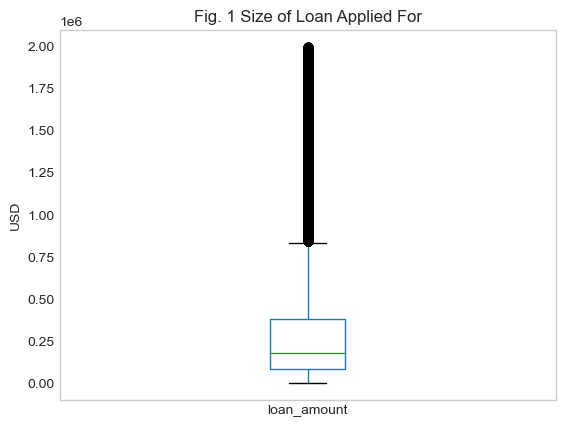

In [79]:
# boxplot for loan amount
df_filtered = df[df['loan_amount'] < 2000000]
df_filtered.boxplot('loan_amount', grid=False)


plt.title('Fig. 1 Size of Loan Applied For')
plt.ylabel('USD')
plt.show()

In Figure 1, we can see that the distribution of loan values has some high outliers.
We set a threshold of $2,000,000 because there were a couple of extreme outliers
preventing us from seeing the spread of the data. This indicates that a few applicants 
requested very large sums of money.

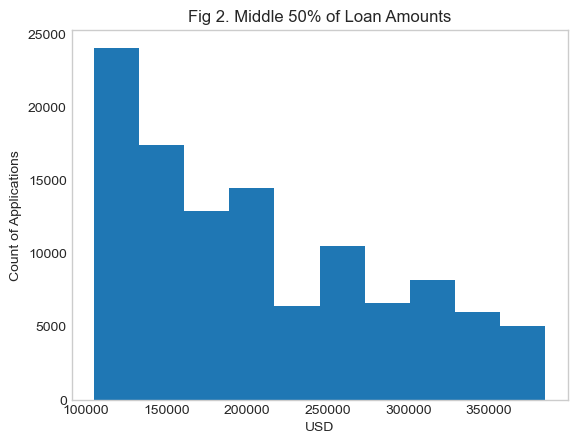

In [80]:
#df_filtered = df[df['loan_amount'] < 750000]

# calculate IQ range
q1, q3 = np.percentile(df['loan_amount'], [25, 75])
df_filtered = df[(df['loan_amount'] > q1) & (df['loan_amount'] < q3) ]

# plot a histogram showing the breakdown of loan values in the middle range
df_filtered.hist('loan_amount', grid=False)
plt.title('Fig 2. Middle 50% of Loan Amounts')
plt.ylabel('Count of Applications')
plt.xlabel('USD')
plt.show()

In Figure 2, we looked at the interquartile range and used the box values to
focus on where most of the data lie. Here we can see that once the especially
large loans are removed, there's a right skew. Far more applications were
requesting around $100,000 than any other value.

In [81]:
# Status labels for legend
status_labels = {
    1: 'Loan Originated',
    2: 'Application Approved but Not Accepted',
    3: 'Application Denied',
    4: 'Application Withdrawn by Applicant',
    5: 'File Closed for Incompleteness',
    6: 'Purchased Loan',
    7: 'Preapproval Request Denied',
    8: 'Preapproval Request Approved but Not Accepted'
}

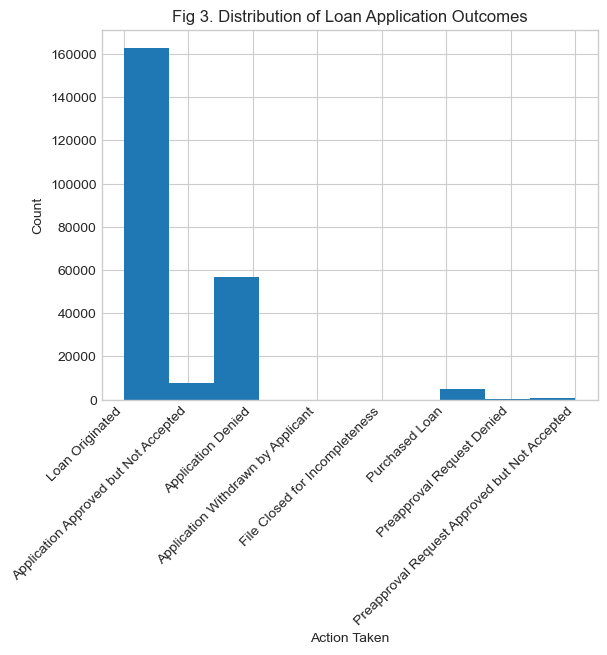

In [82]:
plt.hist(x=df['action_taken'])

plt.xticks(ticks=list(status_labels.keys()), labels=list(status_labels.values()), rotation=45, ha="right")

plt.xlabel("Action Taken")
plt.ylabel("Count")
plt.title("Fig 3. Distribution of Loan Application Outcomes")

plt.show()

Fig 3

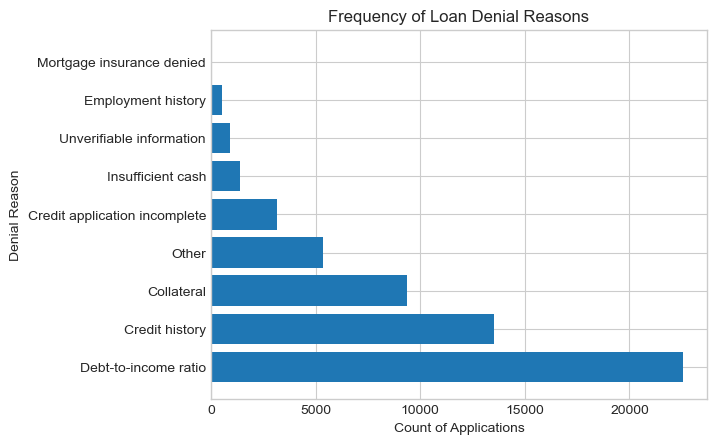

In [83]:
# count occurrences of each denial reason
counts = df['denial_reason-1'].value_counts()

# remove 'Not applicable' and 'Exempt' entries
counts = counts.drop(labels=[10,1111])
denial_reasons = ['Debt-to-income ratio','Credit history','Collateral','Other','Credit application incomplete','Insufficient cash','Unverifiable information','Employment history','Mortgage insurance denied']

# plot reasons
plt.barh(denial_reasons, counts)
plt.ylabel('Denial Reason')
plt.xlabel('Count of Applications')
plt.title('Frequency of Loan Denial Reasons')
plt.show()

This bar plot shows the most common reasons for a loan application to be denied. We can see that the applicant's monthly debt-to-income ratio (usually a value between 20% and 60%) is the most likely cause of rejection, accounting for as many cases as the next two causes combined. Therefore, low-income neighborhoods which are targeted by predatory lending companies may face the most difficulty in achieving home ownership.

# Exploring Correlations

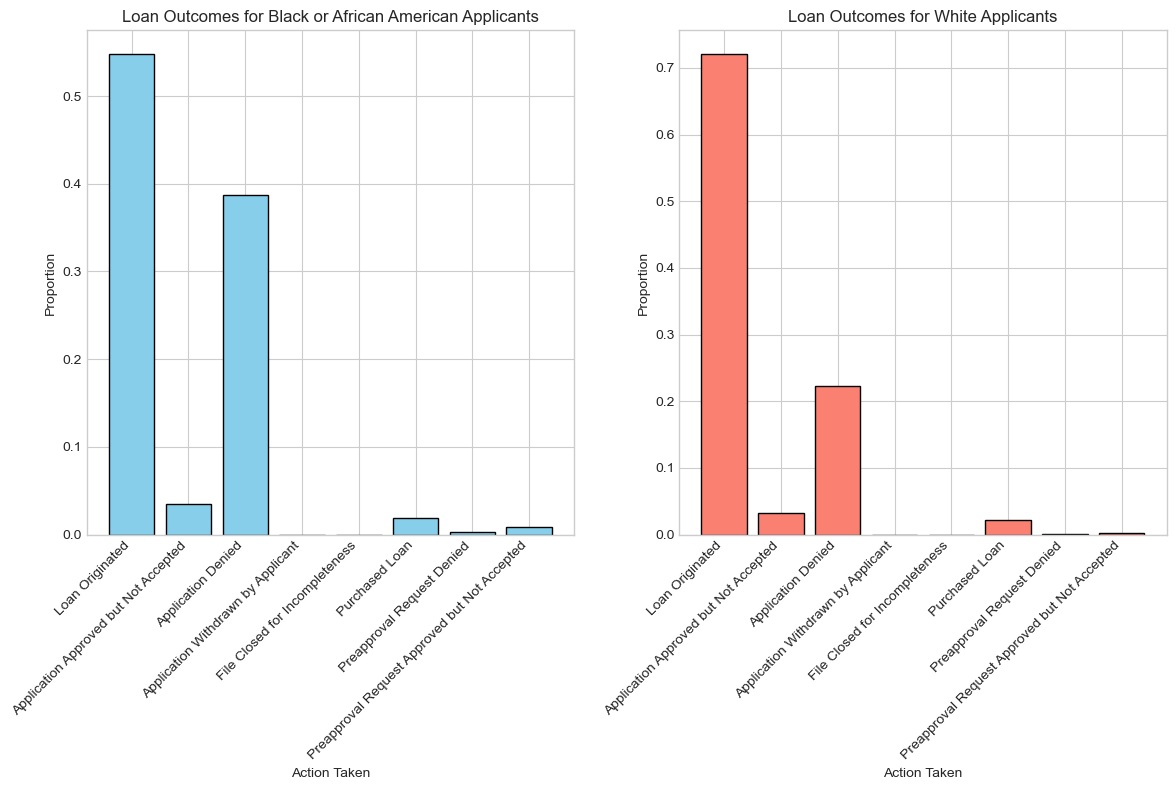

In [88]:
races_of_interest = ['Black or African American', 'White' ]
colors = ['skyblue','salmon']

# Create subplots: one for each race
fig, axes = plt.subplots(nrows=1, ncols=len(races_of_interest), figsize=(12,8))

for ax, race, color in zip(axes, races_of_interest, colors):
    # Uses the race column name to select data
    race_data = df[df['derived_race'] == race]['action_taken']
    race_data = race_data[race_data.isin(status_labels.keys())]

    # Calculate proportions
    value_counts = race_data.value_counts(normalize=True).sort_index()
    proportions = value_counts.reindex(status_labels.keys(), fill_value=0)

    # Plot the histogram for the current race
    ax.bar(proportions.index, proportions.values, color=color, edgecolor='black', width=0.8)

    # Set the x-ticks, labels, title as above
    ax.set_xticks(list(status_labels.keys()))
    ax.set_xticklabels(list(status_labels.values()), rotation=45, ha="right")
    ax.set_xlabel("Action Taken")
    ax.set_ylabel("Proportion")
    ax.set_title(f"Loan Outcomes for {race} Applicants")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

These figures show the outcomes for Black and white applicants, respectively. We can see that the 
proportion of denials for Black applicants is approximately twice as high, and there is also
evidence that slightly more preapproval requests were denied, or approved but then not accepted.
The 'Loan Originated' metric indicates whether the applicants actually received the loan, and
this value is about 15% lower for Black applicants as well. 

/var/folders/bk/9ksdjj7n47qdwk9fmh_w5rbc0000gn/T/ipykernel_51577/426109001.py:46: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/bk/9ksdjj7n47qdwk9fmh_w5rbc0000gn/T/ipykernel_51577/426109001.py:46: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


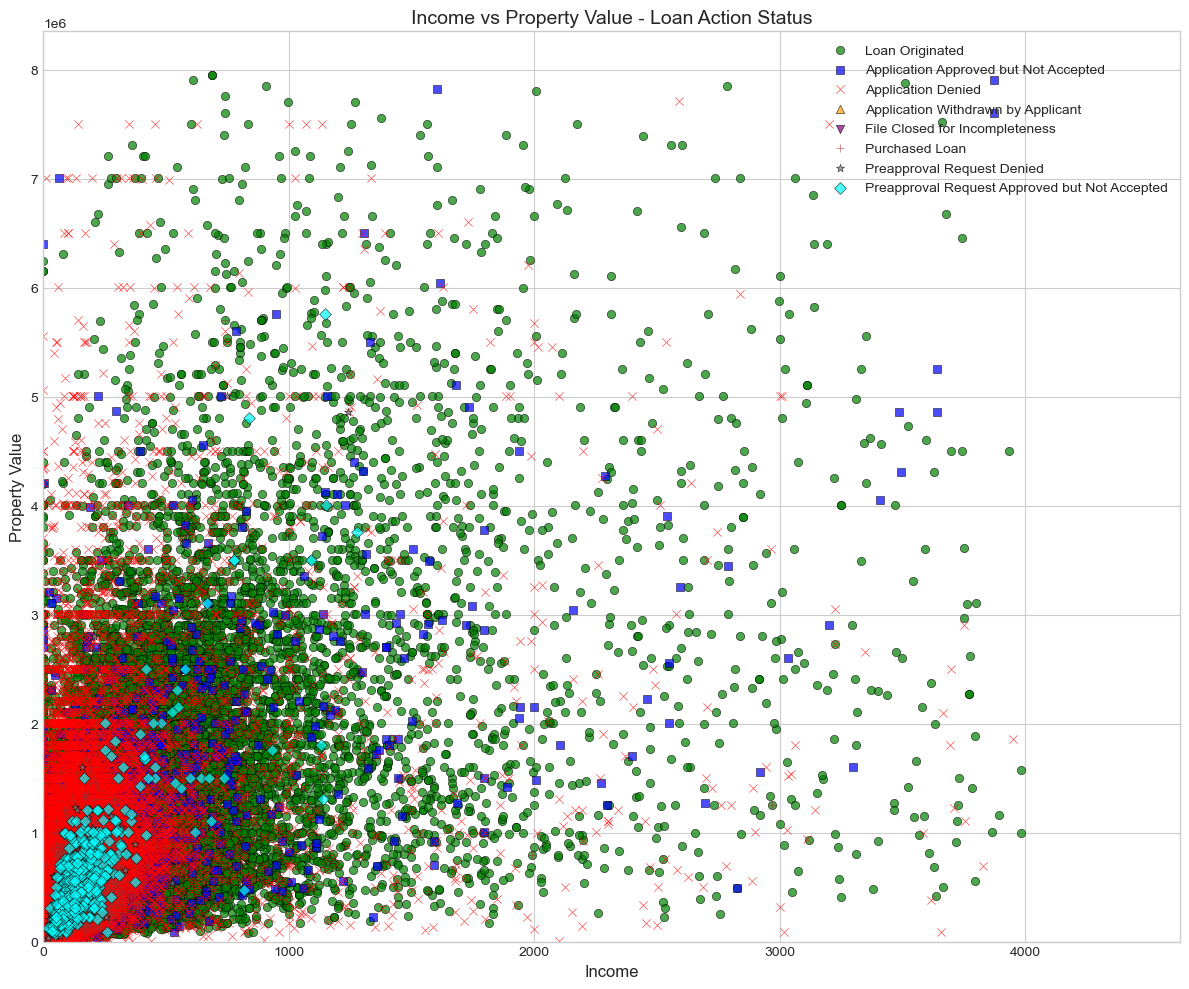

In [89]:
plt.style.use('seaborn-v0_8-whitegrid')

df = df.dropna(subset=['property_value'])
df = df[df['property_value'] < 8000000]
df = df[df['income'] < 4000]

plt.figure(figsize=(12, 10))

markers = {
    1: 'o',   
    2: 's',  
    3: 'x',   
    4: '^',   
    5: 'v',   
    6: '+',  
    7: '*',  
    8: 'D'   
}

colors = {
    1: 'green',    
    2: 'blue',   
    3: 'red',    
    4: 'orange',  
    5: 'purple', 
    6: 'brown',   
    7: 'gray',    
    8: 'cyan'     
}

# Status labels for legend
status_labels = {
    1: 'Loan Originated',
    2: 'Application Approved but Not Accepted',
    3: 'Application Denied',
    4: 'Application Withdrawn by Applicant',
    5: 'File Closed for Incompleteness',
    6: 'Purchased Loan',
    7: 'Preapproval Request Denied',
    8: 'Preapproval Request Approved but Not Accepted'
}

# Create the scatter plot with custom markers for each status
for status in range(1, 9):
    mask = df['action_taken'] == status
    plt.scatter(
        x=df.loc[mask, 'income'], 
        y=df.loc[mask, 'property_value'], 
        marker=markers[status],
        c=colors[status],
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        label=status_labels[status]
    )

plt.xlabel('Income', fontsize=12)
plt.ylabel('Property Value', fontsize=12)
plt.title('Income vs Property Value - Loan Action Status', fontsize=14)

# Set axes to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.legend()
plt.tight_layout()
plt.show()

This figure shows the income of applicants plotted against property value, with different markers indicating the different loan outcomes. From this figure, we can get an idea of which applicants are applying for what types of loans as well as visualizing trends of what is happening with these loans. As expected members higher income tend to apply for higher property loans, but we can also see many members with higher income apply for lower loans and a few members with lower incomes apply for loans for higher property values. This graph also shows how income is strongly right skewed, and also the variability of loans and outcomes that are captured in the dataset.

In [90]:
# transform derived race to binary column for white or Black

df_slice = df.loc[(df['derived_race'] == "Black or African American") | (df['derived_race'] == "White")]
df_race = df_slice.copy()
df_race['binary_race'] = 0
df_race.loc[df_race['derived_race'] == "White", 'binary_race'] = 1

# # transform derived ethnicity to binary column for Hispanic or not
df_race['binary_ethnicity'] = 0
df_race.loc[df_race['derived_ethnicity'] == "Not Hispanic or Latino", 'binary_ethnicity'] = 1

# # create column with 0 for denied applications/preapproval requests and 1 for accepted applications
df_race['binary_denied'] = 0
df_race.loc[(df_race['action_taken'] == 3) | (df_race['action_taken'] == 7), 'binary_denied'] = 1

# # create correlation matrix
df_corr = df_race[['applicant_sex','binary_race','binary_ethnicity','binary_denied']]
df_corr.corr()

,applicant_sex,binary_race,binary_ethnicity,binary_denied
applicant_sex,1.000000,-0.089448,-0.000328,0.020862
binary_race,-0.089448,1.000000,-0.000485,-0.123889
binary_ethnicity,-0.000328,-0.000485,1.000000,-0.064139
binary_denied,0.020862,-0.123889,-0.064139,1.000000


To investigate our hypothesis about loan outcomes being racially biased, we classified each application as being submitted by a white person or a person of color, and by someone Hispanic or not Hispanic. Then we looked for a correlation between the identity information and the outcome. In the 'action_taken' field, a value of 3 indicates the application was denied and 7 indicates that a preapproval requested was denied.

This matrix shows no evidence of strong correlation. It's possible that signs of bias would only show up with a more intersectional analysis.

In [91]:
df_race = df_race.dropna(subset=['interest_rate', 'tract_minority_population_percent', 'applicant_age',
                                 'debt_to_income_ratio', 'income', "property_value", "loan_to_value_ratio", "loan_amount"])

X = df_race[['tract_minority_population_percent', "binary_race", "debt_to_income_ratio", 'income', "property_value"]]
y = df_race['loan_amount']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 2.445e+04
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:25:30   Log-Likelihood:            -9.9736e+05
No. Observations:               73264   AIC:                         1.995e+06
Df Residuals:                   73258   BIC:                         1.995e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Our MLR explains around 71% of the variance in loan amount because the R-squared value is 0.71. All the predictive variables were also statistically significant (tract_minority_population_percent, binary_race, debt_to_income_variable, income, property value, and loans_to_value_ratio) because they all had P-values below 0.05. The model indicates that when controlling for income, property value and other financial factors, race is still a signifcant predictor with white applicants predicted to receive $2500 more for their total loan amount. This model suggests that race is significant and is promising for future analysis. 